In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from statsmodels.tsa.stattools import adfuller as adf
from sklearn.metrics import r2_score
from sklearn.mixture import GaussianMixture
import import_ipynb
import GMMModelling as gmm

In [2]:
gdp = pd.read_csv("US_Nominal_GDP.csv")
debt = pd.read_csv("public_debt.csv")
gdp = gdp.rename(columns={'DATE': 'date', 'NGDPSAXDCUSQ': 'value'})

In [3]:
gdp = gdp.iloc[64:len(gdp)-5, :].reset_index().iloc[:, 1:]

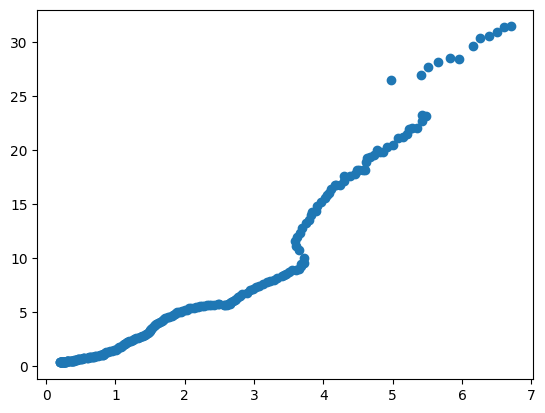

In [4]:
X = np.array(gdp["value"])
Y = np.array(debt["value"])
X = X/1e6
Y = Y/1e6
plt.scatter(X, Y)

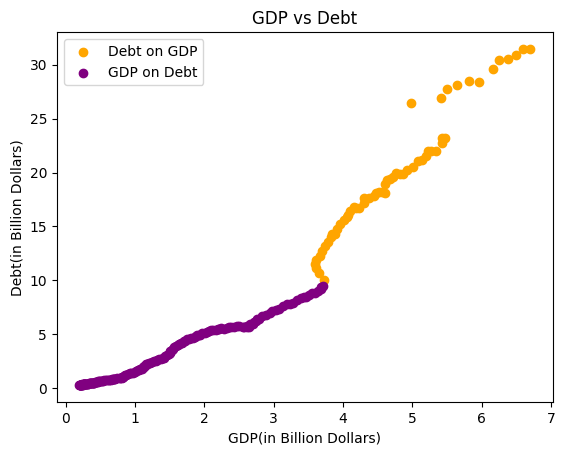

In [5]:
Z = gmm.Z    

X1 = X[Z == 1]
X2 = X[Z == 0]
Y1 = Y[Z == 1]
Y2 = Y[Z == 0]

plt.figure()
plt.scatter(X1, Y1, c = "orange", label = "Debt on GDP")
plt.scatter(X2, Y2, c = "purple", label = "GDP on Debt")
plt.legend()
plt.title("GDP vs Debt")
plt.xlabel("GDP(in Billion Dollars)")
plt.ylabel("Debt(in Billion Dollars)")
plt.show()

In [6]:
def grad_a(X, Y, a, b, c):
    s = 0
    for i in range(0, len(X)):
        if Y[i] - a*X[i]**2 - b*X[i] - c > 0:
            s += -X[i]**2
        else:
            s += X[i]**2
    return s

def grad_b(X, Y, a, b, c):
    s = 0
    for i in range(0, len(X)):
        if Y[i] - a*X[i]**2 - b*X[i] - c > 0:
            s += -X[i]
        else:
            s += X[i]
    return s

def grad_c(X, Y, a, b, c):
    s = 0
    for i in range(0, len(X)):
        if Y[i] - a*X[i]**2 - b*X[i] - c > 0:
            s += -1
        else:
            s += 1
    return s

In [7]:
def weighted_simple(X, Y, w):
    Y_new = Y/np.sqrt(w)
    X_new_1 = X/np.sqrt(w)
    X_new_2 = X**2/np.sqrt(w)
    X_new_0 = 1/np.sqrt(w)
    X_new = np.column_stack((X_new_2, X_new_1, X_new_0))
    Y_new = np.column_stack((Y_new)).T
    p = np.dot(np.dot(np.linalg.inv(np.dot(X_new.T, X_new)), X_new.T), Y_new)
    p = p.T[0]
    return p

In [8]:
def weighted_linear(X, Y, w):
    Y_new = Y/np.sqrt(w)
    X_new_1 = X/np.sqrt(w)
    X_new_0 = 1/np.sqrt(w)
    X_new = np.column_stack((X_new_1, X_new_0))
    Y_new = np.column_stack((Y_new)).T
    p = np.dot(np.dot(np.linalg.inv(np.dot(X_new.T, X_new)), X_new.T), Y_new)
    p = p.T[0]
    return p

In [9]:
def grad_a(x, y, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2*x**2)
def grad_b(x, y, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2*x)
def grad_c(x, y, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2)
def swap_grad_a(x, y, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(-b/a**2 + (b**2 + 4*a*y - 4*a*c)**0.5 / (2*a**2) - (y-c)/(a*(b**2 + 4*a*y - 4*a*c)**0.5))
def swap_grad_b(x, y, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(1/(2*a) - b/(2*a*(b**2 + 4*a*y - 4*a*c)**0.5))
def swap_grad_c(x, y, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(2/(b**2 + 4*a*y - 4*a*c)**0.5)
def grad_lin_m(x, y, m, c):
    return (y - m*x - c)*(-2*x)
def grad_lin_c(x, y, m, c):
    return (y - m*x - c)*(-2)
def swap_grad_lin_m(x, y, m, c):
    return (x - (y - c)/m)*(2*(y - c)/m**2)
def swap_grad_lin_c(x, y, m, c):
    return (x - (y - c)/m)*(2/m)

In [10]:
def grad_w_a(x, y, w, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2*x**2)/w
def grad_w_b(x, y, w, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2*x)/w
def grad_w_c(x, y, w, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2)/w
def grad_w_lin_m(x, y, w, m, c):
    return (y - m*x - c)*(-2*x)/w
def grad_w_lin_c(x, y, w, m, c):
    return (y - m*x - c)*(-2)/w
def swap_grad_w_a(x, y, w, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(-b/a**2 + (b**2 + 4*a*y - 4*a*c)**0.5 / (2*a**2) - (y-c)/(a*(b**2 + 4*a*y - 4*a*c)**0.5))/w
def swap_grad_w_b(x, y, w, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(1/(2*a) - b/(2*a*(b**2 + 4*a*y - 4*a*c)**0.5))/w
def swap_grad_w_c(x, y, w, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(2/(b**2 + 4*a*y - 4*a*c)**0.5)/w
def swap_grad_w_lin_m(x, y, w, m, c):
    return (x - (y - c)/m)*(2*(y - c)/m**2)/w
def swap_grad_w_lin_c(x, y, w, m, c):
    return (x - (y - c)/m)*(2/m)/w

In [11]:
def Swap(X, Y, Z, a0 = None, b0 = None, c0 = None, epochs = 1e5, lr = 1e-7, error = 0.25, ers = 1e-2):
    if a0 == None:
        [a0, b0, c0] = np.polyfit(X, Y, 2)
    a = a0
    b = b0
    c = c0
    L = []
    ep = []
    for e in tqdm(range(0, int(epochs))):
        gA = 0
        gB = 0
        gC = 0
        err = 0
        for i in range(0, len(Z)):
            if Z[i] == 1:
                gA += lr*grad_a(X[i], Y[i], a, b, c)
                gB += lr*grad_b(X[i], Y[i], a, b, c)
                gC += lr*grad_c(X[i], Y[i], a, b, c)
            if Z[i] == 0:
                try:
                    if b**2 + 4*a*Y[i] - 4*a*c < 0:
                        err += 1
                    else:
                        gA += lr*swap_grad_a(X[i], Y[i], a, b, c)
                        gB += lr*swap_grad_b(X[i], Y[i], a, b, c)
                        gC += lr*swap_grad_c(X[i], Y[i], a, b, c)
#                    print(gA, gB, gC)
                except:
                    err += 1
        gA /= (len(X) - err)
        gB /= (len(X) - err)
        gC /= (len(X) - err)
        ep.append(e + 1)
        L.append(gA**2 + gB**2 + gC**2)
        if err/len(Z) < error:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        else:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        if gA**2 + gB**2 + gC**2 < ers:
            plt.plot(ep, L)
            print(gA**2 + gB**2 + gC**2)
            return [a, b, c]
        if e == int(epochs) - 1:
            print(gA**2 + gB**2 + gC**2)
    print("Meh.")
 #   plt.plot(ep, L)
    return [a, b, c]

In [12]:
def Swap_Weighted(X, Y, Z, w, a0 = None, b0 = None, c0 = None, epochs = 1e5, lr = 1e-7, error = 0.25, ers = 1e-2):
    if a0 == None:
        [a0, b0, c0] = np.polyfit(X, Y, 2)
    a = a0
    b = b0
    c = c0
    L = []
    ep = []
    for e in tqdm(range(0, int(epochs))):
        gA = 0
        gB = 0
        gC = 0
        err = 0
        for i in range(0, len(Z)):
            if Z[i] == 1:
                gA += lr*grad_w_a(X[i], Y[i], math.fabs(Y[i] - a*X[i]**2 - b*X[i] - c), a, b, c)
                gB += lr*grad_w_b(X[i], Y[i], math.fabs(Y[i] - a*X[i]**2 - b*X[i] - c), a, b, c)
                gC += lr*grad_w_c(X[i], Y[i], math.fabs(Y[i] - a*X[i]**2 - b*X[i] - c), a, b, c)
            if Z[i] == 0:
                try:
                    if b**2 + 4*a*Y[i] - 4*a*c < 0:
                        err += 1
                    else:
                        gA += lr*swap_grad_w_a(X[i], Y[i], math.fabs(X[i] + b/(2*a) - math.sqrt(b**2 + 4*a*c - 4*a*Y[i])/(2*a)), a, b, c)
                        gB += lr*swap_grad_w_b(X[i], Y[i], math.fabs(X[i] + b/(2*a) - math.sqrt(b**2 + 4*a*c - 4*a*Y[i])/(2*a)), a, b, c)
                        gC += lr*swap_grad_w_c(X[i], Y[i], math.fabs(X[i] + b/(2*a) - math.sqrt(b**2 + 4*a*c - 4*a*Y[i])/(2*a)), a, b, c)
#                    print(gA, gB, gC)
                except:
                    err += 1
        gA /= (len(X) - err)
        gB /= (len(X) - err)
        gC /= (len(X) - err)
        ep.append(e + 1)
        L.append(gA**2 + gB**2 + gC**2)
        if err/len(Z) < error:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        else:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        if gA**2 + gB**2 + gC**2 < ers:
            plt.plot(ep, L)
            print(gA**2 + gB**2 + gC**2)
            return [a, b, c]
        if e == int(epochs) - 1:
            print(gA**2 + gB**2 + gC**2)
    print("Meh.")
    return [a, b, c]

In [13]:
def Swap_Weighted_Lin(X, Y, Z, w, m0 = None, c0 = None, epochs = 1e5, lr = 1e-7, error = 0.25, ers = 1e-2):
    if m0 == None:
        [m0, c0] = np.polyfit(X, Y, 1)
    m = m0
    c = c0
    L = []
    ep = []
    for e in tqdm(range(0, int(epochs))):
        gM = 0
        gC = 0
        for i in range(0, len(Z)):
            if Z[i] == 1:
                gM += lr*grad_w_lin_m(X[i], Y[i], math.fabs(Y[i] - m*X[i] - c), m, c)
                gC += lr*grad_w_lin_c(X[i], Y[i], math.fabs(Y[i] - m*X[i] - c), m, c)
            if Z[i] == 0:
                    gM += lr*swap_grad_w_lin_m(X[i], Y[i], math.fabs(X[i] - (Y[i] - c)/m), m, c)
                    gC += lr*swap_grad_w_lin_c(X[i], Y[i], math.fabs(X[i] - (Y[i] - c)/m), m, c)
        gM /= len(X)
        gC /= len(X)
        L.append(gM**2 + gC**2)
        if gM**2 + gC**2 < ers:
#            plt.plot(ep, L)
            print(gM**2 + gC**2)
            return [m, c]
        if e == int(epochs) - 1:
            print(gM**2 + gC**2)
    print("Meh.")
    return [m, c]

In [14]:
def L1_linear(X, Y, eps = 1e-3):
    Beta0 = np.polyfit(X, Y, 1)
    w = np.abs(Y - Beta0[0] * X - Beta0[1])
    Beta1 = weighted_linear(X, Y, w)
    e = 1
    while (np.linalg.norm(Beta0 - Beta1) > eps):
        Beta0 = Beta1
        w = np.abs(Y - Beta0[0] * X - Beta0[1])
        Beta1 = weighted_linear(X, Y, w)
        e += 1
    return Beta0

In [15]:
def SwapLin(X, Y, Z, m0 = None, c0 = None, epochs = 1e5, lr = 1e-7, error = 0.25, ers = 1e-2):
    if m0 == None:
        [m0, c0] = np.polyfit(X, Y, 1)
    m = m0
    c = c0
    L = []
    ep = []
    for e in tqdm(range(0, int(epochs))):
        gM = 0
        gC = 0
        err = 0
        for i in range(0, len(Z)):
            if Z[i] == 1:
                gM += lr*grad_lin_m(X[i], Y[i], m, c)
                gC += lr*grad_lin_c(X[i], Y[i], m, c)
            if Z[i] == 0:
                gM += lr*swap_grad_lin_m(X[i], Y[i], m, c)
                gC += lr*swap_grad_lin_c(X[i], Y[i], m, c)
        gM /= len(X)
        gC /= len(X)
        ep.append(e + 1)
        L.append(gM**2 + gC**2)
        if err/len(Z) < error:
            m -= gM * lr
            c -= gC * lr
        else:
            m -= gM * lr
            c -= gC * lr
        if gM**2 + gC**2 < ers:
            plt.plot(ep, L)
            print(gM**2 + gC**2)
            return [m, c]
        if e == int(epochs) - 1:
            print(gM**2 + gC**2)
    print("Meh.")
    plt.plot(ep, L)
    return [m, c]

In [16]:
def L1_linear_swap(X, Y, eps = 1e-3):
    Beta0 = np.array(SwapLin(X, Y, Z))
    print("Step 1")
    w = np.abs(Y - Beta0[0] * X - Beta0[1])
    Beta1 = np.array(Swap_Weighted_Lin(X, Y, Z, w))
    print("Step 2")
    e = 1
    while (np.linalg.norm(Beta0 - Beta1) > eps):
        print(e)
        Beta0 = Beta1.copy()
        w = np.abs(Y - Beta0[0] * X - Beta0[1])
        Beta1 = np.array(Swap_Weighted_Lin(X, Y, Z, w))
        e += 1
        print(Beta0 - Beta1)
        print(np.linalg.norm(Beta0 - Beta1))
    return Beta0

In [17]:
def L1_simple(X, Y, eps = 1e-3):
    Beta0 = np.polyfit(X, Y, 2)
    w = np.abs(Y - Beta0[0] * X**2 - Beta0[1] * X - Beta0[2])
    Beta1 = weighted_simple(X, Y, w)
    e = 1
    while (np.linalg.norm(Beta0 - Beta1) > eps):
        Beta0 = Beta1
        w = np.abs(Y - Beta0[0] * X**2 - Beta0[1] * X - Beta0[2])
        Beta1 = weighted_simple(X, Y, w)
        e += 1
    return Beta0

In [18]:
def L1_swap(X, Y, Z, eps = 1e-3, lrs = 1e-6, lrw = 1e-6):
    Beta0 = np.array(Swap(X, Y, Z, lr = lrs))
    print("Step 1")
    w = np.abs(Y - Beta0[0] * X**2 - Beta0[1] * X - Beta0[2])
    Beta1 = np.array(Swap_Weighted(X, Y, Z, w, lr = lrw))
    print("Step 2")
    e = 1
    while (np.linalg.norm(Beta0 - Beta1) > eps):
        print(e)
        Beta0 = Beta1.copy()
        w = np.abs(Y - Beta0[0] * X**2 - Beta0[1] * X - Beta0[2])
        Beta1 = np.array(Swap_Weighted(X, Y, Z, w, lr = lrw))
        e += 1
        print(Beta0 - Beta1)
        print(np.linalg.norm(Beta0 - Beta1))
    return Beta0

In [19]:
p = L1_simple(X, Y)
p

array([ 0.58982848,  1.17061799, -0.01448315])

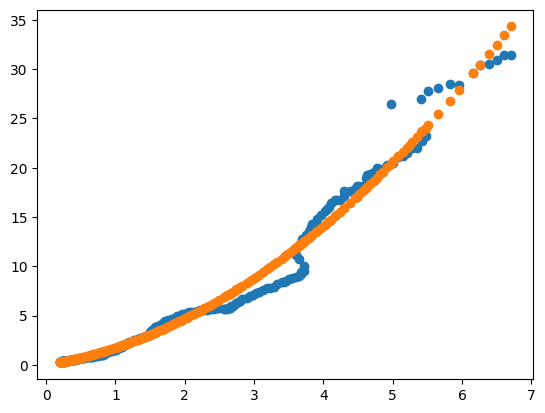

In [20]:
Y_fit = p[0]*X**2 + p[1]*X + p[2]
plt.scatter(X, Y)
plt.scatter(X, Y_fit)

  0%|                                                | 0/100000 [00:00<?, ?it/s]


2.0476396088218615e-25
Step 1


  0%|                                                | 0/100000 [00:00<?, ?it/s]

2.963289523885463e-23
Step 2


array([0.64606567, 0.85782727, 0.11587015])

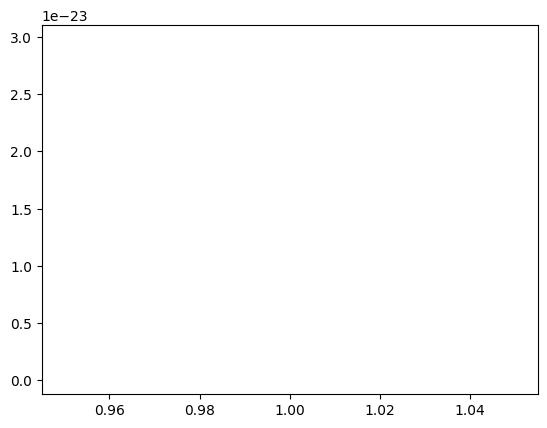

In [21]:
ps = L1_swap(X, Y, Z, lrs = 1e-13, lrw = 1e-12, eps = 1e-48)
ps

In [22]:
l = L1_linear(X, Y)
l

array([ 4.47297417, -2.68125833])

  0%|                                                | 0/100000 [00:00<?, ?it/s]


1.457532253059518e-13
Step 1


  0%|                                                | 0/100000 [00:00<?, ?it/s]

2.1223332699849015e-14
Step 2


array([ 4.49724772, -2.8404832 ])

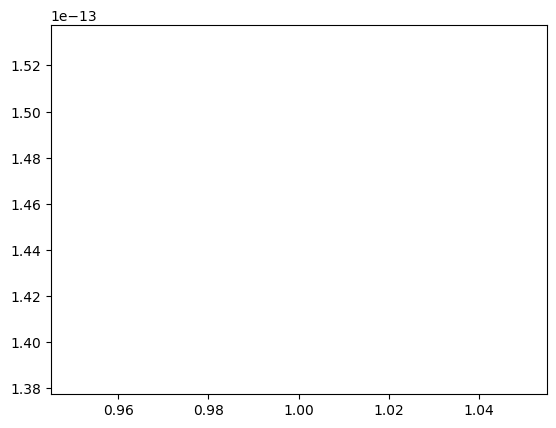

In [23]:
ls = L1_linear_swap(X, Y)
ls

In [24]:
def errorQuad(X, Y, Z, a, b, c):
    e = 0
    err = 0
    for i in (range(0, len(Z))):
        if Z[i] == 1:
            e += math.fabs(Y[i] - a*X[i]**2 - b*X[i] - c)
        else:
            if (b**2 - 4*a*c + 4*a*Y[i]) >= 0:
                e += math.fabs((X[i] + b/(2*a) - ((b**2 - 4*a*c + 4*a*Y[i])**0.5)/(2*a))**2)
            else:
                err += 1
    return e/(len(X) - err - 3)

In [25]:
def errorLin(X, Y, Z, m, c):
    e = 0
    for i in range(0, len(Z)):
        if Z[i] == 1:
            e += math.fabs(Y[i] - m*X[i] - c)
        else:
            e += math.fabs(X[i] - (Y[i] - c)/m)
    return e/(len(X) - 2)

In [26]:
print("Linear L1 Norm : " + str(errorLin(X, Y, Z, l[0], l[1])))
print("Linear SWAP L1 Norm : " + str(errorLin(X, Y, Z, ls[0], l[1])))
print("Simple L1 Norm : " + str(errorQuad(X, Y, Z, p[0], p[1], p[2])))
print("SWAP L1 Norm : " + str(errorQuad(X, Y, Z, ps[0], ps[1], ps[2])))

Linear L1 Norm : 0.7395584633116512
Linear SWAP L1 Norm : 0.722902581646162
Simple L1 Norm : 0.3295762485332074
SWAP L1 Norm : 0.3560305596881032


In [27]:
Y_lin = l[0]*X + l[1]
Y_lin_swap = ls[0]*X + ls[1]
Y_simple = p[0]*X**2 + p[1]*X + p[2]
Y_swap = ps[0]*X**2 + ps[1]*X + ps[2]
X_swap = -ps[1]/(2*ps[0]) + np.sqrt(ps[1]**2 - 4*ps[0]*(ps[2] - Y))/(2*ps[0])
X_simple = -p[1]/(2*p[0]) + np.sqrt(p[1]**2 - 4*p[0]*(p[2] - Y))/(2*p[0])

In [28]:
def makeLine(x, y, m, c):
    x0 = min(x)
    x1 = max(x)
    return [x0, x1], [m*x0 + c, m*x1 + c]

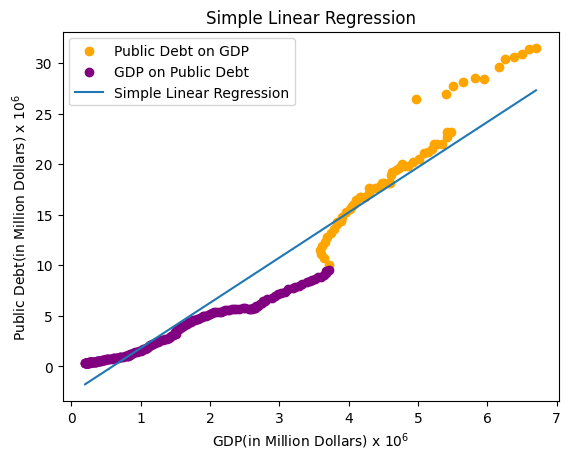

In [29]:
plt.scatter(X1, Y1, label = "Public Debt on GDP", c = "orange")
plt.scatter(X2, Y2, label = "GDP on Public Debt", c = "purple")
A, B = makeLine(X, Y, l[0], l[1])
plt.plot(A, B, label = "Simple Linear Regression")
plt.title("Simple Linear Regression")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

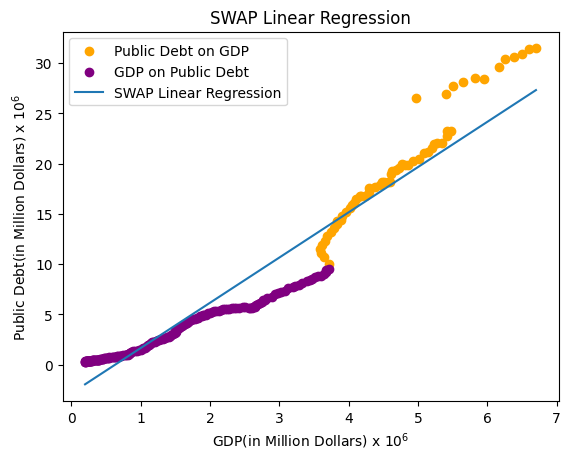

In [30]:
plt.scatter(X1, Y1, label = "Public Debt on GDP", c = "orange")
plt.scatter(X2, Y2, label = "GDP on Public Debt", c = "purple")
A, B = makeLine(X, Y, ls[0], ls[1])
plt.plot(A, B, label = "SWAP Linear Regression")
plt.title("SWAP Linear Regression")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

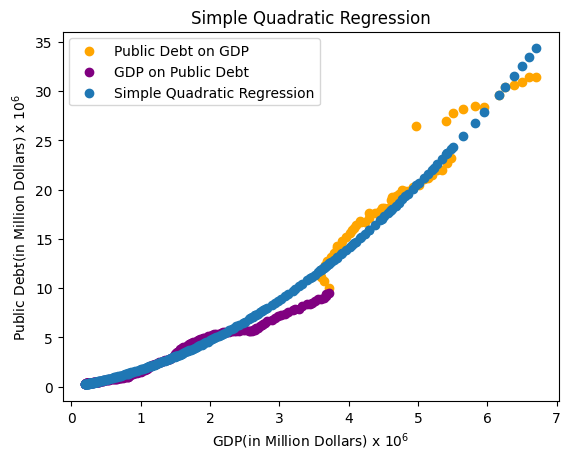

In [31]:
plt.scatter(X1, Y1, label = "Public Debt on GDP", c = "orange")
plt.scatter(X2, Y2, label = "GDP on Public Debt", c = "purple")
plt.scatter(X, Y_simple, label = "Simple Quadratic Regression")
plt.title("Simple Quadratic Regression")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

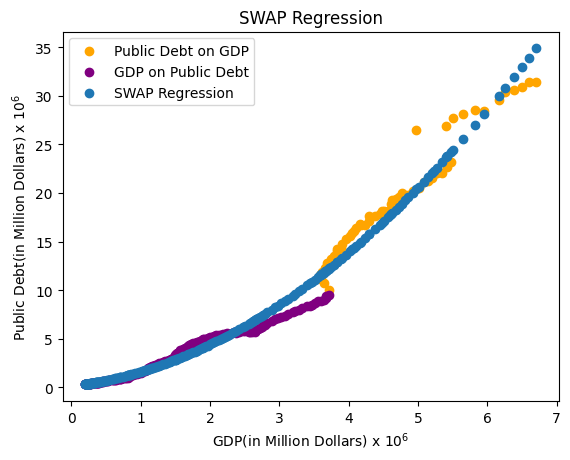

In [32]:
plt.scatter(X1, Y1, label = "Public Debt on GDP", c = "orange")
plt.scatter(X2, Y2, label = "GDP on Public Debt", c = "purple")
plt.scatter(X, Y_swap, label = "SWAP Regression")
plt.title("SWAP Regression")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

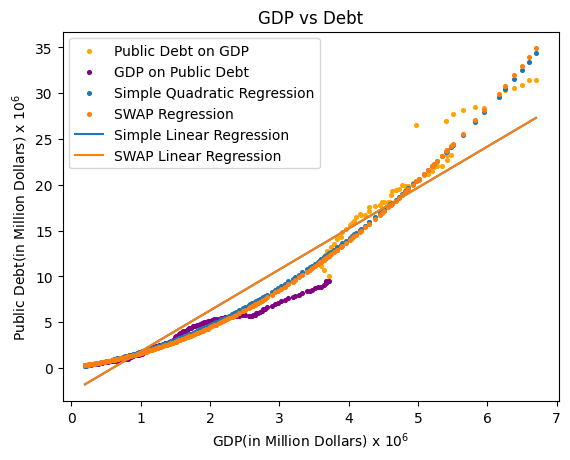

In [33]:
A1, B1 = makeLine(X, Y, l[0], l[1])
A2, B2 = makeLine(X, Y, l[0], l[1])
plt.scatter(X1, Y1, label = "Public Debt on GDP", c = "orange", s = 7)
plt.scatter(X2, Y2, label = "GDP on Public Debt", c = "purple", s = 7)
plt.scatter(X, Y_simple, label = "Simple Quadratic Regression", s = 7)
plt.scatter(X, Y_swap, label = "SWAP Regression", s = 7)
#plt.scatter(X, Y_lin, label = "Linear")
plt.plot(A1, B1, label = "Simple Linear Regression")
plt.plot(A2, B2, label = "SWAP Linear Regression")
#plt.scatter(X, Y_lin_swap, label = "Linear SWAP")
plt.title("GDP vs Debt")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

In [34]:
e_swap = Y_swap - Y
e_simple = Y_simple - Y

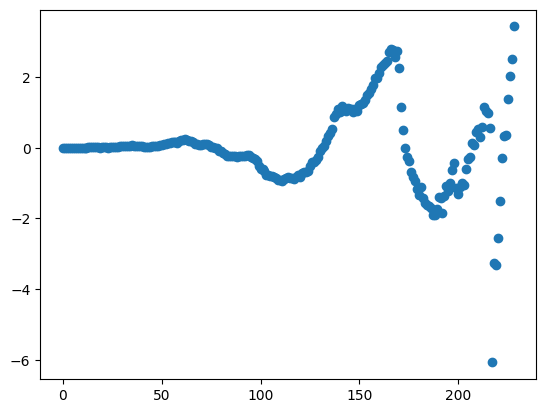

In [35]:
plt.scatter(list(range(0, len(e_swap))), e_swap)

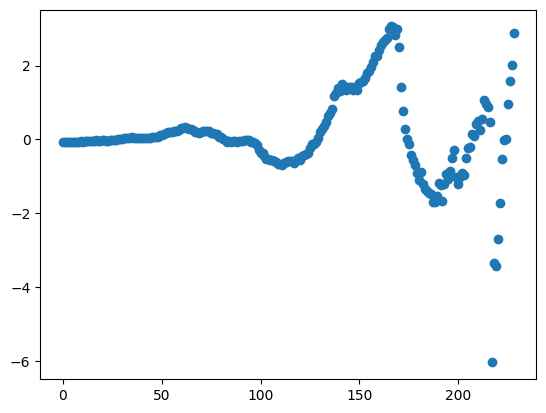

In [36]:
plt.scatter(list(range(0, len(e_swap))), e_simple)

In [37]:
r2_score(Y, Y_swap)

0.981941925989069

In [38]:
r2_score(Y, Y_simple)

0.9813355703482077

In [39]:
adf(e_swap)

(-3.2816443626757255,
 0.015719176867689085,
 3,
 225,
 {'1%': -3.4597521044060353,
  '5%': -2.874472927517147,
  '10%': -2.5736628197530864},
 342.23337450734556)

In [40]:
adf(e_simple)

(-3.3111739363813792,
 0.014386327990235528,
 3,
 225,
 {'1%': -3.4597521044060353,
  '5%': -2.874472927517147,
  '10%': -2.5736628197530864},
 331.6885256275962)

In [41]:
sse_quad_1 = sum(((Y - Y_simple)[Z == 1])**2)
sse_quad_swap_1 = sum(((Y - Y_swap)[Z == 1])**2)
sse_quad_0 = sum(((Y - Y_simple)[Z == 0])**2)
sse_quad_swap_0 = sum(((Y - Y_swap)[Z == 0])**2)
sse_quad_swap_swap_0 = sum(((X - X_swap)[Z == 0])**2)

In [42]:
DF = pd.DataFrame({"Simple Regression Sum of Squares" : [sse_quad_1, sse_quad_0], "SWAP Regression Sum of Squares" : [sse_quad_swap_1, sse_quad_swap_0], "Error in Prediction" : [sse_quad_1, sse_quad_swap_swap_0]})
DF.index = ["Z = 1", "Z = 0"]
DF

,Simple Regression Sum of Squares,SWAP Regression Sum of Squares,Error in Prediction
Z = 1,136.231217,153.271289,136.231217
Z = 0,149.141683,122.830636,6.304931


In [43]:
True_Value = list(Y[Z == 1])
True_Value.extend(list(X[Z == 0]))
Prediction_swap = list(Y_swap[Z == 1])
Prediction_swap.extend(list(X_swap[Z == 0]))
Prediction_simple = list(Y_simple[Z == 1])
Prediction_simple.extend(list(X_simple[Z == 0]))

In [44]:
r2_score(True_Value, Prediction_swap)

0.9905210981405349

In [45]:
r2_score(True_Value, Prediction_simple)

0.9914726461499358

Text(0, 0.5, 'Predicted Value')

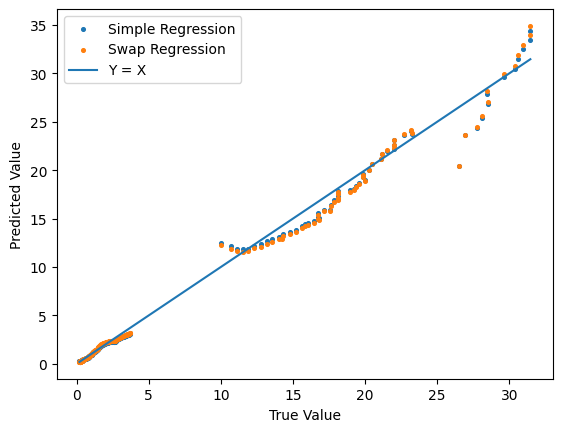

In [46]:
plt.scatter(True_Value, Prediction_simple, label = "Simple Regression", s = 7)
plt.scatter(True_Value, Prediction_swap, label = "Swap Regression", s = 7)
plt.plot([min(True_Value), max(True_Value)], [min(True_Value), max(True_Value)], label = "Y = X")
plt.legend()
plt.xlabel("True Value")
plt.ylabel("Predicted Value")